# Test of Forel Ule on satellite images

Test images used in WW2015 and W2016:
* ENVISAT_MERIS_RR.20060504T100254.L2.OC.nc
* AQUA_MODIS.20060504T115501

S3 image of LiverpoolBay
* S3A_OL_20200506T104005_20200506T104305_20200507T143731_0179_058_051_1980_LN1_O_NT_002' (processed with Polymer)
* S3A_OL_2_WFR____20200506T104005_20200506T104305_20200507T211159_0179_058_051_1980_MAR_O_NT_002 (L2 from EUMETSAT)

Other S3 images
* S3B_OL_1_EFR____20200112T045045_20200112T045345_20200113T085230_0179_034_190_2700_LN1_O_NT_002'
* S3B_OL_1_EFR____20200109T042519_20200109T042819_20200114T040052_0179_034_147_2520_MAR_O_NT_002'

**References**

*Wernand, M. R., Hommersom, a., & Van Der Woerd, H. J. (2013). MERIS-based ocean colour classification with the discrete Forel-Ule scale. Ocean Science, 9, 477–487.* doi:10.5194/os-9-477-2013

*Van der Woerd, H. J., Wernand, M., Peters, M., Bala, M., and Brockmann, C. 2016. True color analysis of natural waters with SeaWiFS, MODIS, MERIS and OLCI by SNAP. In Proceedings of the Ocean Optics XXIII, Victoria, BC, Canada, pp. 23–28.*

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import xarray as xr
import fume
import numpy as np

In [2]:
bands_meris={'red':'Rrs_665','green':'Rrs_560','blue':'Rrs_443'}
bands_modis={'red':'Rrs_667','green':'Rrs_555','blue':'Rrs_443'}
bands_olci={'red':'Rw665','green':'Rw560','blue':'Rw443'}
bands_olci_eumetsat={'red':'Oa03_reflectance','green':'Oa06_reflectance','blue':'Oa08_reflectance'}


## Auxiliary plotting functions 

In [3]:
def _extent(rcextent):
    
    rstep,cstep=(1,1)
    if rcextent:
        ri,rf,ci,cf = rcextent
        if ri>rf:
            rstep=-1
        if ci>cf:
            cstep=-1
    else:
        ri,rf,ci,cf = 0,-1,0,-1
        
    return ri,rf,rstep,ci,cf,cstep


def plot_rgb_image(ax, imgfile,bands,rcextent=None):
    
    ri,rf,rstep,ci,cf,cstep = _extent(rcextent)
    
    try:
        img = xr.open_dataset(imgfile,group='geophysical_data')
    except OSError:
        img = xr.open_dataset(imgfile)
        
    redb=bands['red']
    greenb=bands['green']
    blueb=bands['blue']

    #fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(10,8))
    #ax=axs
    print(img[redb].shape)
    try:
        # for meris images
        rgb = xr.concat([img[redb][ri:rf:rstep,ci:cf:cstep], 
                         img[greenb][ri:rf:rstep,ci:cf:cstep],
                         img[blueb][ri:rf:rstep,ci:cf:cstep]
                        ],
                         dim='rgb').transpose('number_of_lines', 'pixels_per_line','rgb')
    except ValueError:
        try:
            # for olci images
            rgb = xr.concat([img[redb][ri:rf:rstep,ci:cf:cstep], 
                             img[greenb][ri:rf:rstep,ci:cf:cstep],
                             img[blueb][ri:rf:rstep,ci:cf:cstep]
                            ],
                             dim='rgb').transpose('height', 'width','rgb')
        except ValueError:
            # for olci EUMETSAT images
            rgb = xr.concat([img[redb][ri:rf:rstep,ci:cf:cstep], 
                             img[greenb][ri:rf:rstep,ci:cf:cstep],
                             img[blueb][ri:rf:rstep,ci:cf:cstep]
                            ],
                             dim='rgb').transpose('y', 'x','rgb')
    
    ax.imshow(rgb/rgb.quantile(0.95),interpolation='none')
        
    return ax


def plot_fu_image(ax, imgfile,reflectance_prefix,sensorcorr,rcextent=None):

    ri,rf,rstep,ci,cf,cstep = _extent(rcextent)

    try:
        img = xr.open_dataset(imgfile,group='geophysical_data')
    except OSError:
        img = xr.open_dataset(imgfile)

    # Extract wavelengths from band names
    wavelength = []
    bandid = []
    for var in img.data_vars:
        if reflectance_prefix in var:
            bandid.append(var)
            try:
                wavelength.append( int ( var.replace(reflectance_prefix,'') ) )
            except ValueError: 
                wavelength.append( float(img[var].attrs['radiation_wavelength']) )

    # Create a 3-D array along wavelength dimension
    Rw = xr.concat( [img[id][ri:rf:rstep,ci:cf:cstep] for id in bandid] ,dim='wavelength')

    #Rw.name = 'Rw'
    Rw = Rw.assign_coords(wavelength=wavelength)


    # Calculate Forel-Ule classes
    fu,_ = fume.calc_ForelUle_image(Rw.coords['wavelength'].values, 
                                    Rw,
                                    sensorcorr=sensorcorr,
                                    fucalibration='data/hue_angle_limits_NWW2013.csv')
        
    # Plot image and return axis 
    mapp = ax.imshow(fu, cmap=fume.forelulecmap(),vmin=0.5,vmax=21.5,interpolation='none')
    cbar = plt.colorbar(mapp, ax=ax)
    cbar.set_ticks(range(1,21+1))
    cbar.set_ticklabels(range(1,21+1))
    cbar.set_label('Forel Ule classes')

    return ax


def plot_ha_image(ax,imgfile,reflectance_prefix,sensorcorr,rcextent=None):

    ri,rf,rstep,ci,cf,cstep = _extent(rcextent)
    
    try:
        img = xr.open_dataset(imgfile,group='geophysical_data')
    except OSError:
        img = xr.open_dataset(imgfile)

    # Extract wavelengths from band names
    wavelength = []
    bandid = []
    #print(img.data_vars)
    for var in img.data_vars:
        if reflectance_prefix in var:
            bandid.append(var)
            try:
                wavelength.append( int ( var.replace(reflectance_prefix,'') ) )
            except ValueError: 
                wavelength.append( float(img[var].attrs['radiation_wavelength']) )

    # Create a 3-D array along wavelength dimension
    Rw = xr.concat( [img[id][ri:rf:rstep,ci:cf:cstep] for id in bandid] ,dim='wavelength')
    
    #Rw.name = 'Rw'
    Rw = Rw.assign_coords(wavelength=wavelength)


    # Calculate and plot Forel-Ule classes
    _,ha = fume.calc_ForelUle_image(Rw.coords['wavelength'].values, 
                                    Rw,
                                    sensorcorr=sensorcorr,
                                    fucalibration='data/hue_angle_limits_NWW2013.csv')
    
    #fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,8))
    mapp = ax.imshow(ha, cmap=cm.jet_r,vmin=0,vmax=270,interpolation='none')
    cbar = plt.colorbar(mapp, ax=ax)
    cbar.set_label('Hue angle (deg.)')

    return ax

# North Sea: : Polymer vs. Baseline AC
### Images from WW2015 and WWPB2016 papers 

### ENVISAT_MERIS_RR.20060504T100254.L2.OC.nc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14993, 1121)


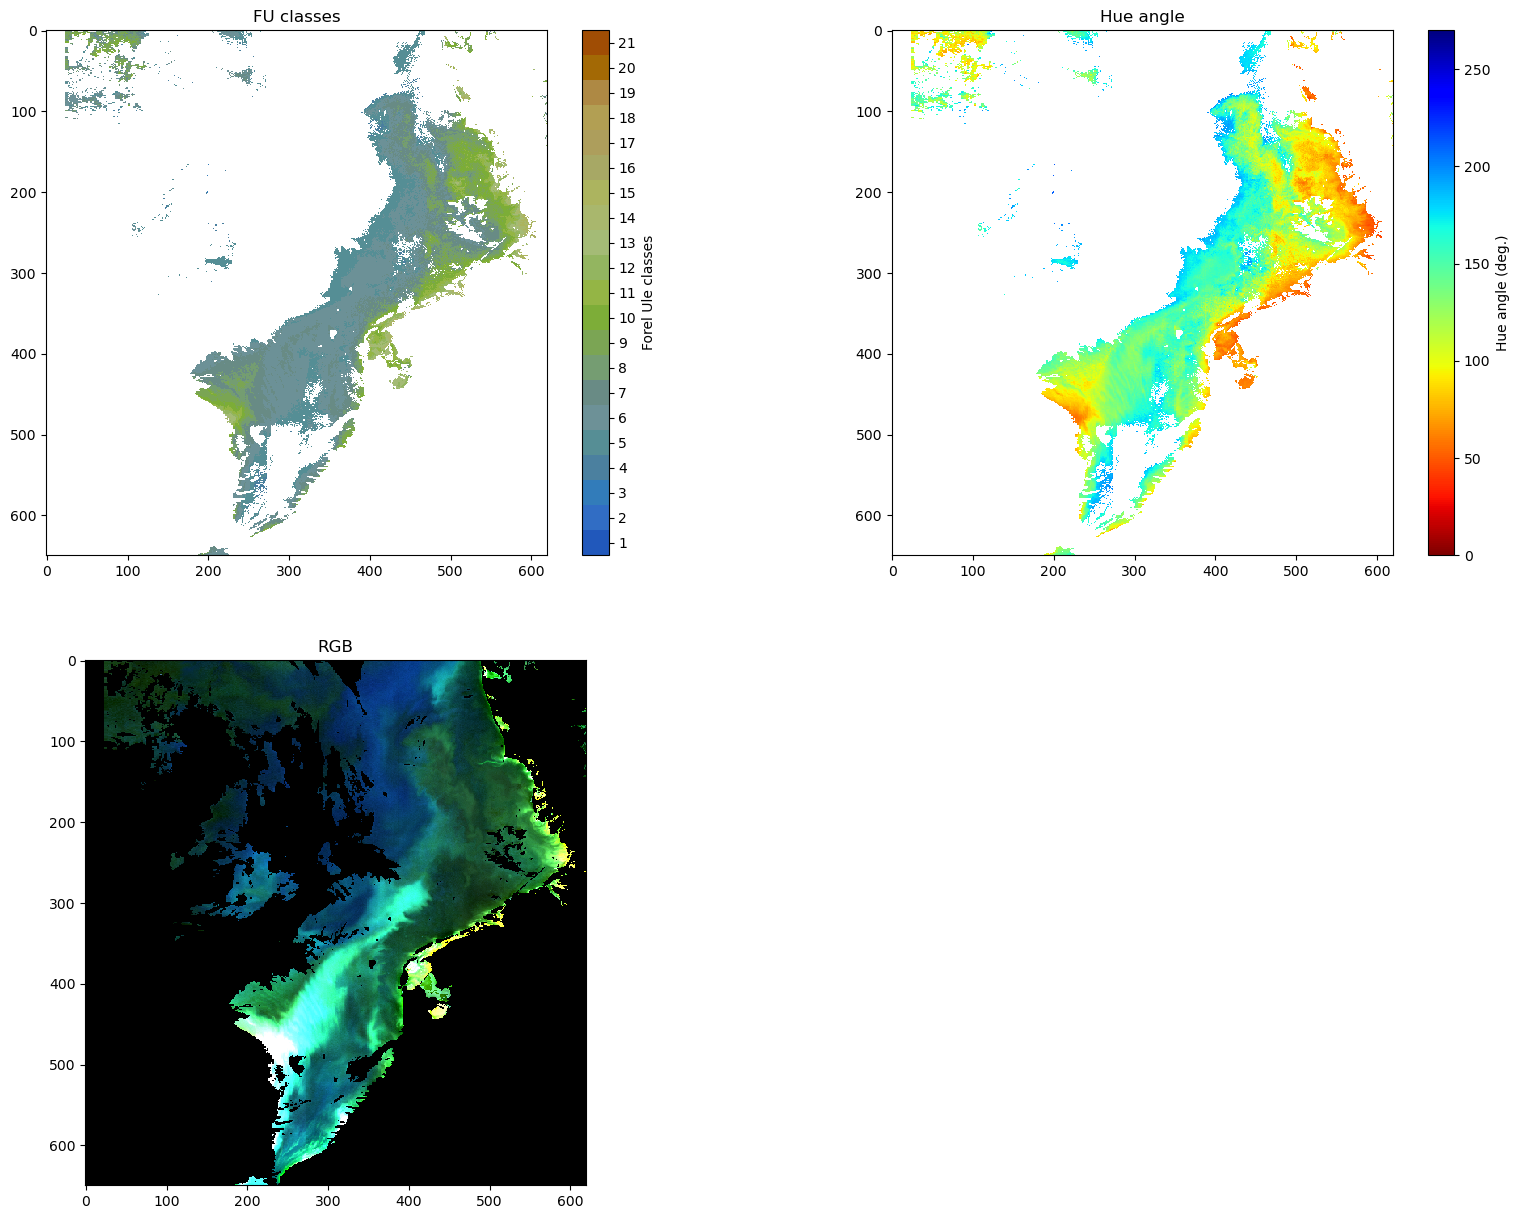

In [4]:
fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(20,15))
axs=axs.flatten()

imagepath='data/ENVISAT_MERIS_RR.20060504T100254.L2.OC.nc'

ax1 = plot_fu_image(axs[0],imagepath,
                    reflectance_prefix='Rrs_',
                    sensorcorr='meris',
                    rcextent=[4150,4800,0,620])
ax1.set_title('FU classes')

ax2 = plot_ha_image(axs[1],imagepath,
                    reflectance_prefix='Rrs_',
                    sensorcorr='meris',
                    rcextent=[4150,4800,0,620])
ax2.set_title('Hue angle')

ax3 = plot_rgb_image(axs[2],imagepath,
                    bands=bands_meris,
                    rcextent=[4150,4800,0,620])
ax3.set_title('RGB')

plt.delaxes(axs[3])


### AQUA_MODIS.20060504T115501

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2030, 1354)


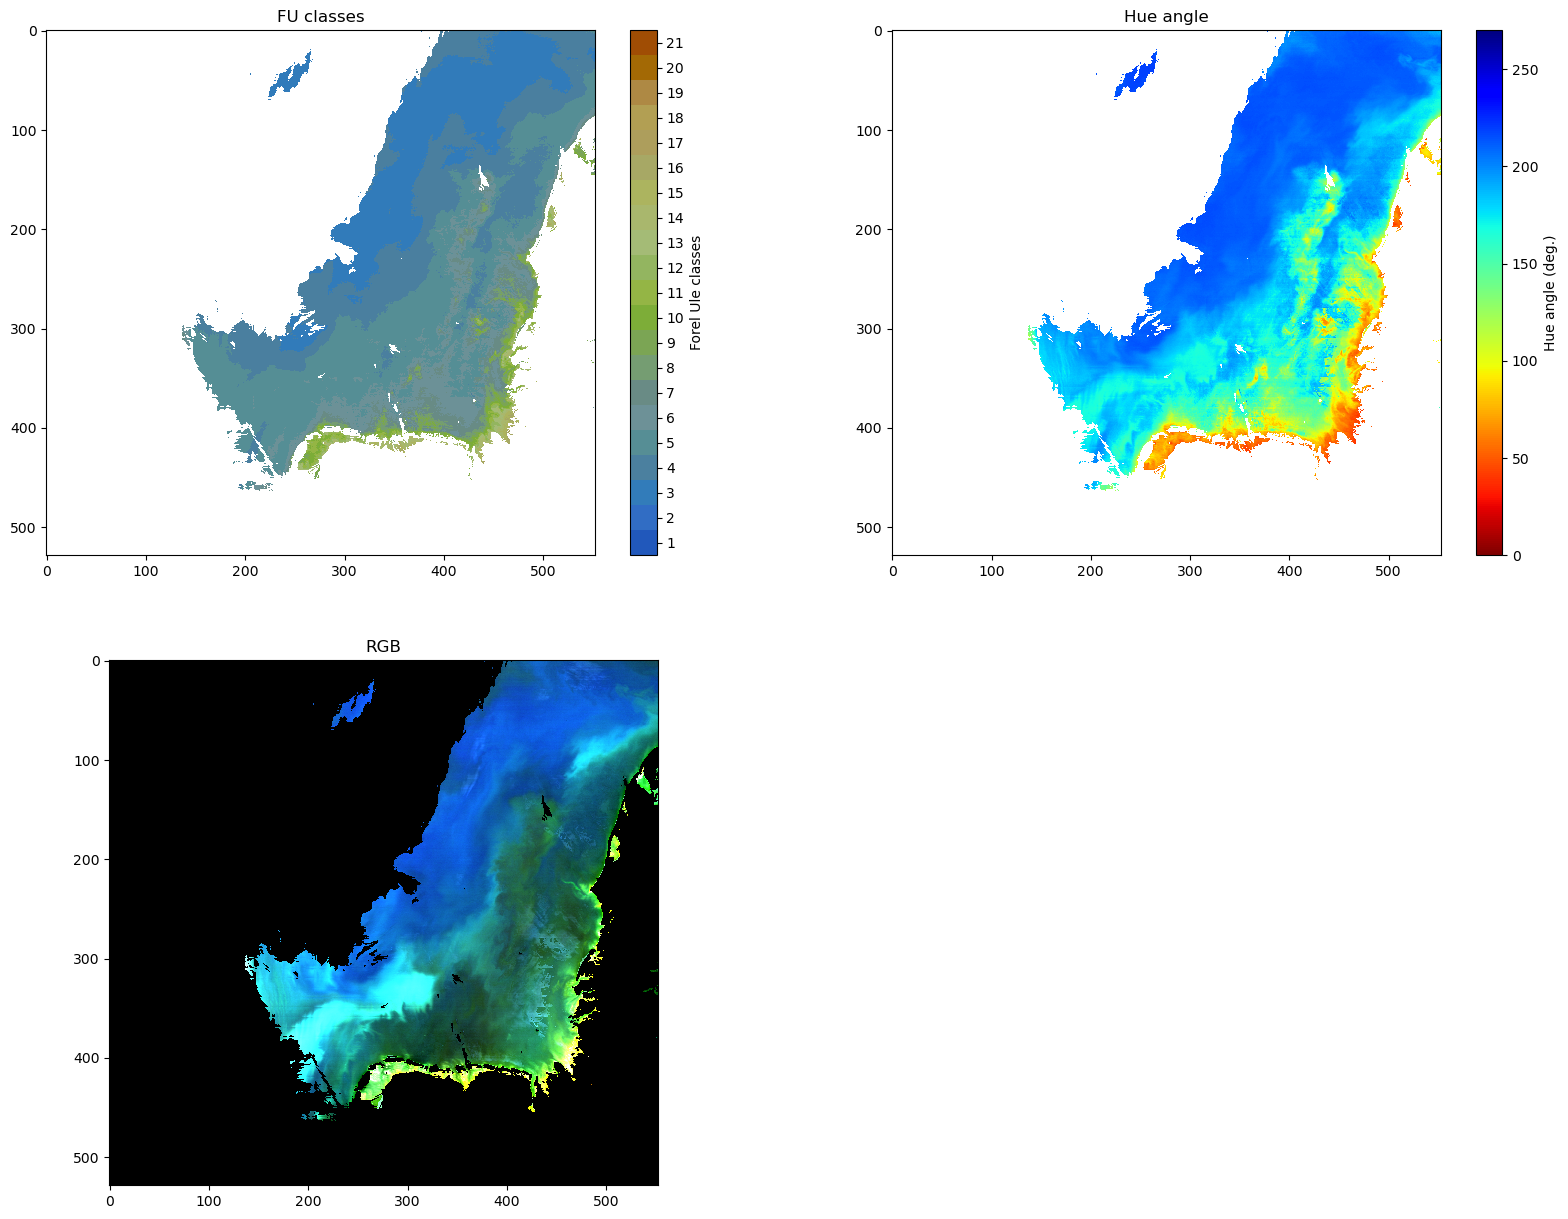

In [5]:
fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(20,15))
axs=axs.flatten()

imagepath = 'data/AQUA_MODIS.20060504T115501.L2.OC.nc'

ax1 = plot_fu_image(axs[0],imagepath,
                    reflectance_prefix='Rrs_',
                    sensorcorr='modisa',
                    rcextent=[2030,1500,1354,800])
ax1.set_title('FU classes')

ax2 = plot_ha_image(axs[1],imagepath,
                    reflectance_prefix='Rrs_',
                    sensorcorr='modisa',
                    rcextent=[2030,1500,1354,800])
ax2.set_title('Hue angle')

ax3 = plot_rgb_image(axs[2],imagepath,
               bands=bands_modis,
               rcextent=[2030,1500,1354,800])
ax3.set_title('RGB')

plt.delaxes(axs[3])

# Liverpool Bay test: Polymer vs. Baseline AC

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(200, 250)
(196, 218)


Text(0.5, 1.0, 'RGB Baseline AC')

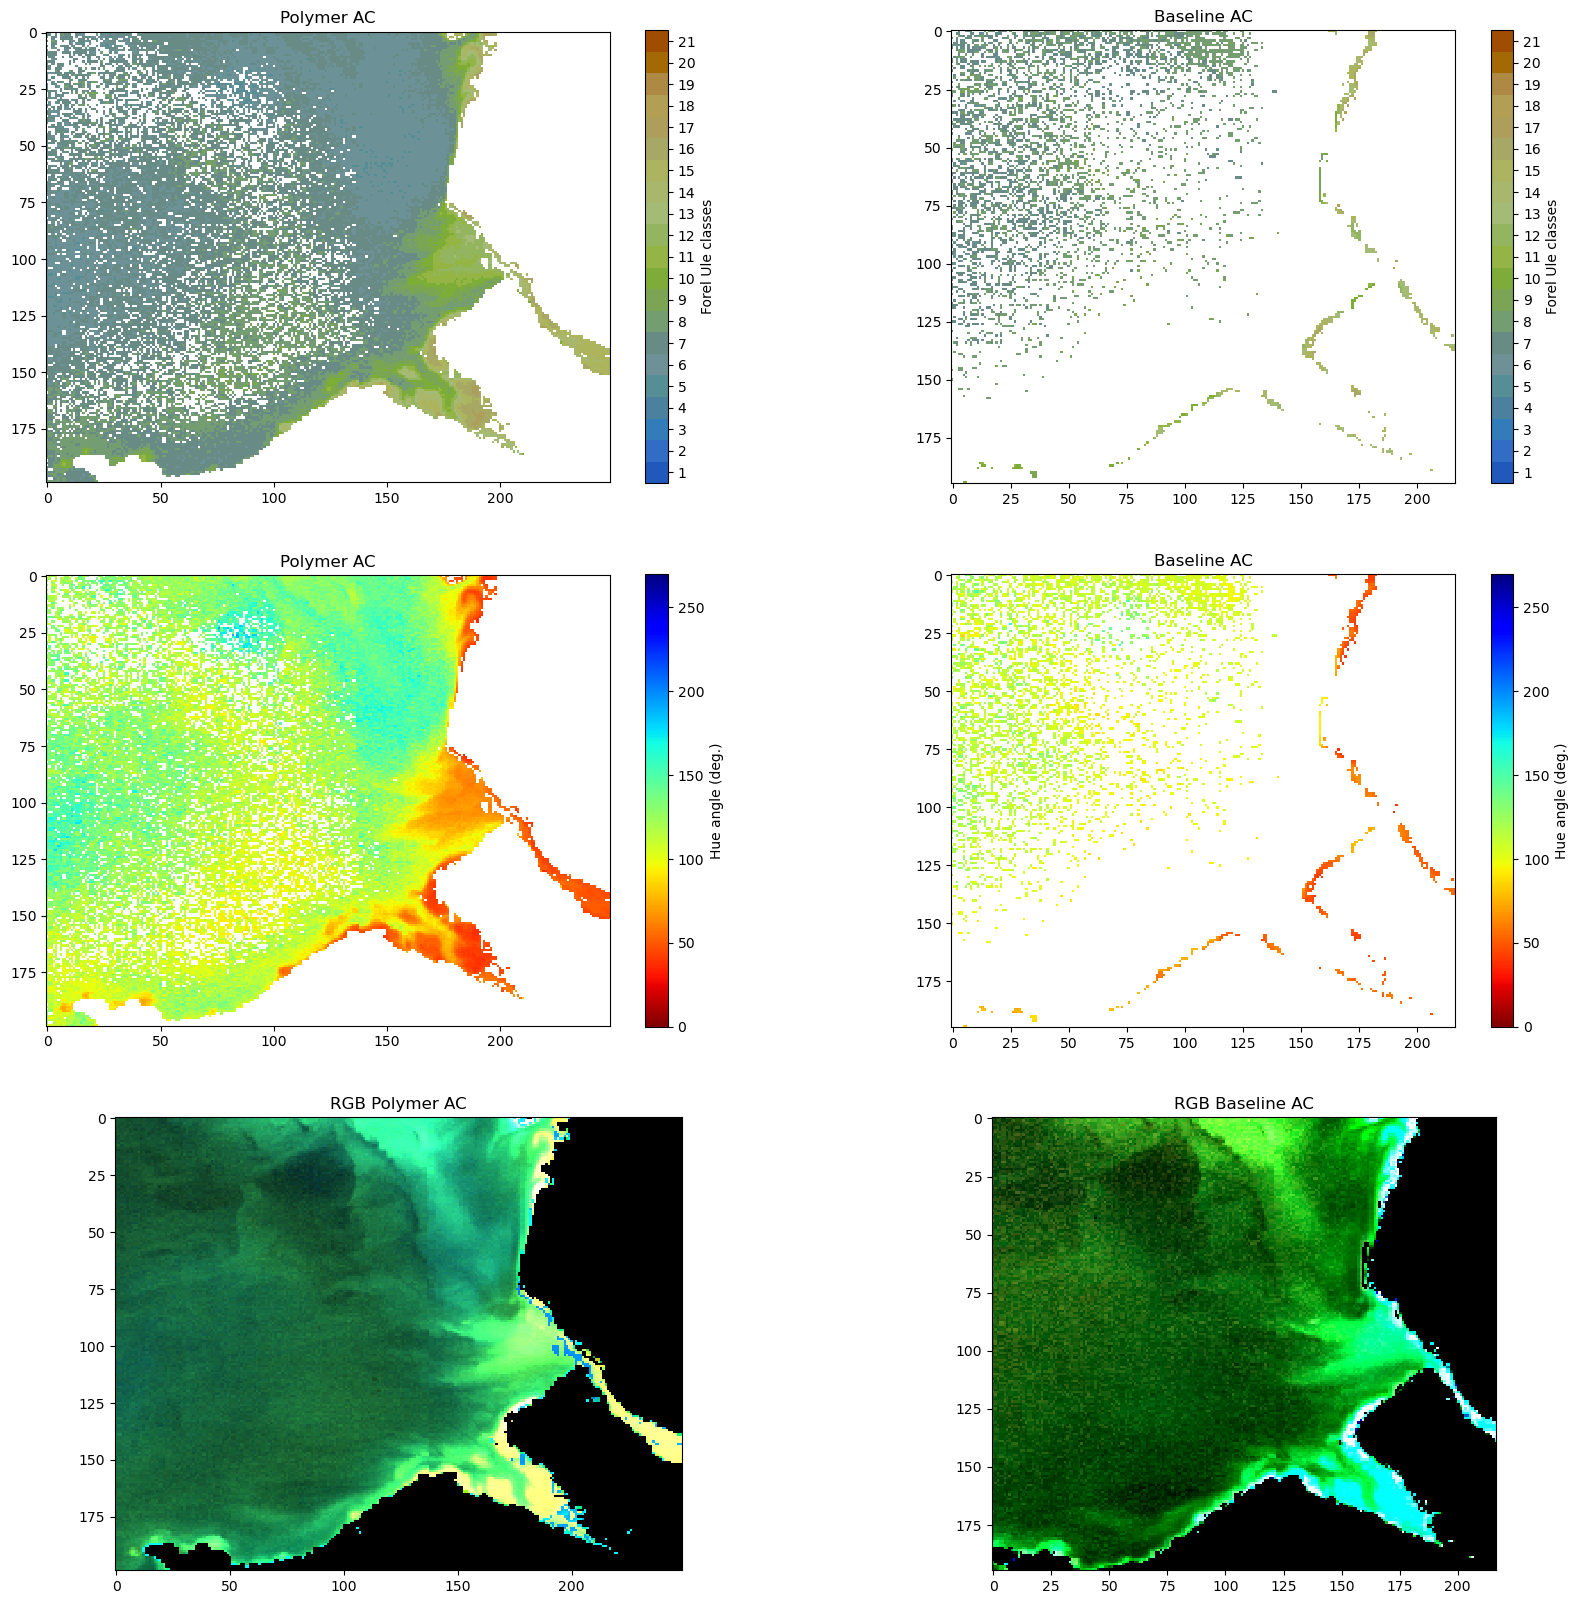

In [6]:
fig,axs = plt.subplots(nrows=3,ncols=2,figsize=(20,20))

imagepath1='data/S3A_OL_20200506T104005_20200506T104305_20200507T143731_0179_058_051_1980_LN1_O_NT_002.polymer.LivBay.nc'
imagepath2='data/S3A_OL_2_WFR____20200506T104005_20200506T104305_20200507T211159_0179_058_051_1980_MAR_O_NT_002.LivBay.nc'

ax1 = plot_fu_image(axs[0,0],imagepath1,
             reflectance_prefix='Rw',
             sensorcorr='olci')
ax1.set_title('Polymer AC')

ax2 = plot_fu_image(axs[0,1],imagepath2,
             reflectance_prefix='_reflectance',
             sensorcorr='olci')
ax2.set_title('Baseline AC')

ax3 = plot_ha_image(axs[1,0],imagepath1,
             reflectance_prefix='Rw',
             sensorcorr='olci')
ax3.set_title('Polymer AC')

ax4 = plot_ha_image(axs[1,1],imagepath2,
             reflectance_prefix='_reflectance',
             sensorcorr='olci')
ax4.set_title('Baseline AC')

ax5 = plot_rgb_image(axs[2,0],imagepath1,
             bands=bands_olci)
ax5.set_title('RGB Polymer AC')

ax6 = plot_rgb_image(axs[2,1],imagepath2,
             bands=bands_olci_eumetsat)
ax6.set_title('RGB Baseline AC')

## Plot all the bands

C:\Users\tams00\AppData\Local\mambaforge\envs\FUME\Lib\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


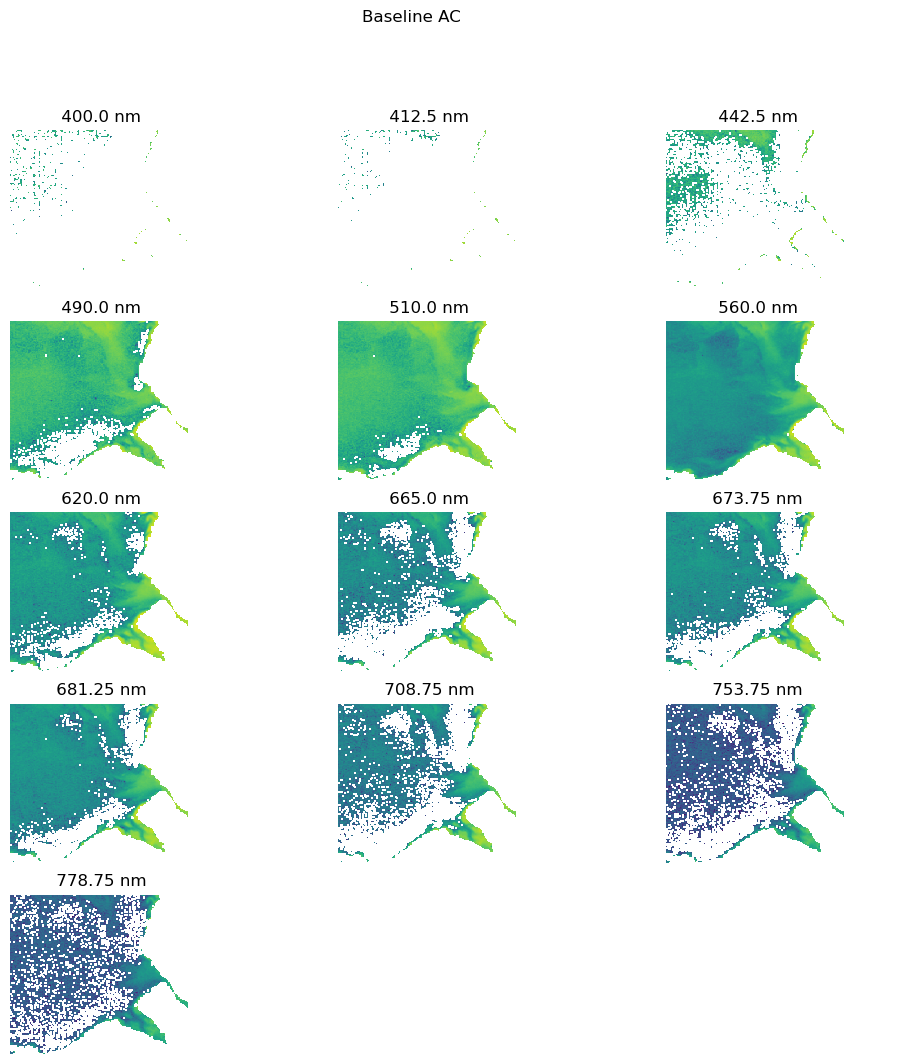

In [7]:
baseline = xr.open_dataset(imagepath2)
bands = [var for var in list( baseline.data_vars ) if ('reflectance' in var and (baseline[var].attrs['radiation_wavelength'])<800)]
fig,axs = plt.subplots(nrows=5,ncols=3,figsize=(12,12))
axs= axs.flatten()
fig.suptitle('Baseline AC')

for iband,band in enumerate(bands):
    axs[iband].imshow(np.log(baseline[band]))
    axs[iband].set_title( f" {baseline[band].attrs['radiation_wavelength']} nm"  )
    axs[iband].set_axis_off()

# Disable empty axes
for iband in range(iband, 15):
    axs[iband].set_axis_off()

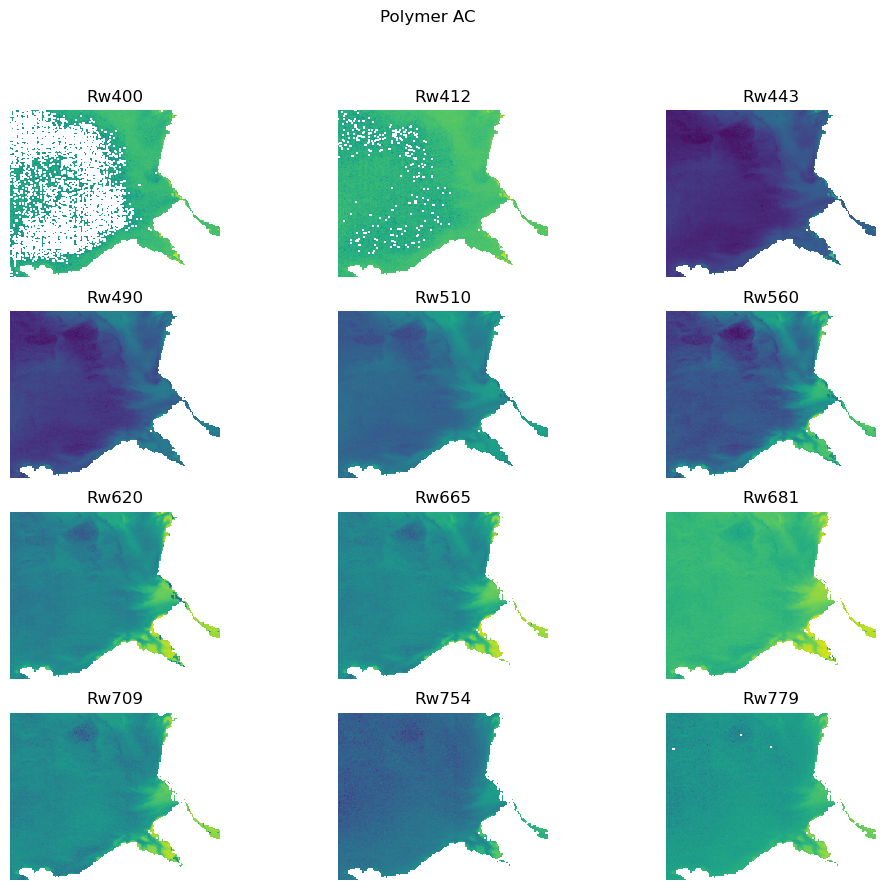

In [8]:
polymer = xr.open_dataset(imagepath1)
bands = [var for var in list( polymer.data_vars ) if 'Rw' in var]
fig,axs = plt.subplots(nrows=4,ncols=3,figsize=(12,10))
axs= axs.flatten()
fig.suptitle('Polymer AC')

for iband,band in enumerate(bands):
    axs[iband].imshow(np.log(polymer[band]))
    axs[iband].set_title(band)
    axs[iband].set_axis_off()

# Other test images

In [ ]:

polymersmallfile='data/S3B_OL_1_EFR____20200112T045045_20200112T045345_20200113T085230_0179_034_190_2700_LN1_O_NT_002.polymer.vembanad_lake.nc'
#polymersmallfile='data/S3B_OL_1_EFR____20200109T042519_20200109T042819_20200114T040052_0179_034_147_2520_MAR_O_NT_002.polymer.chilika_lake.nc'

fig,axs = plt.subplots(nrows=3,ncols=1,figsize=(15,30))
axs=axs.flatten()

ax1 = plot_fu_image(axs[0],polymersmallfile,
                    reflectance_prefix='Rw',
                    sensorcorr='olci')

ax2 = plot_ha_image(axs[1],polymersmallfile,
                    reflectance_prefix='Rw',
                    sensorcorr='olci')

ax3 = plot_rgb_image(axs[2],polymersmallfile,
                    bands=bands_olci)